In [4]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.text import Text

ModuleNotFoundError: No module named 'cartopy'

In [2]:
train_file = 'data/out/train_cleaned.csv'
test_file = 'data/out/test_cleaned.csv'

In [3]:
train_data = pd.read_csv(train_file)
train_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test_data = pd.read_csv(test_file)
test_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia,tiempo,distancia_api,tiempo_api,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,13573.1,1285.1,...,1,0,0,0,0,0,0,0,0,0
1,124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,14549.1,1210.1,...,1,0,0,0,0,0,0,0,0,0
2,124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,58253.0,3680.0,...,0,0,0,0,0,0,0,0,0,0
3,124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,23597.4,1472.8,...,0,0,0,0,0,0,0,0,0,0
4,124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,14608.3,1154.8,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia_api,tiempo_api,region_origen_Amazonas,region_origen_Ancash,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,76381.7,4891.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,124606.8,10232.9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,20630.3,1631.7,0,0,...,1,0,0,0,0,0,0,0,0,0
3,124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,12105.8,1067.6,0,0,...,1,0,0,0,0,0,0,0,0,0
4,124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,9403.2,652.5,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(1952, 59)

In [7]:
test_data.shape

(852, 57)

In [8]:
X=train_data.loc[:,train_data.columns.isin(['id','fecha','distancia','tiempo']) == False].values
y=train_data.iloc[:,6:8].values
yhat=test_data.iloc[:,2:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, ..., 0.        , 0.        ,
        0.        ],
       [0.74842017, 0.22806174, 0.72358461, ..., 0.        , 0.        ,
        0.        ],
       [0.4134065 , 0.34430488, 0.41945535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, ..., 0.        , 0.        ,
        0.        ],
       [0.40340026, 0.3552709 , 0.42098601, ..., 0.        , 0.        ,
        0.        ],
       [0.15010318, 0.93230005, 0.23882396, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=2)
clustering = cluster_model.fit(X)

In [11]:
from joblib import dump

dump(cluster_model, 'data/out/cluster_model_t9.joblib') 

['data/out/cluster_model_t9.joblib']

In [12]:
clustering.labels_

array([0, 0, 0, ..., 0, 1, 0])

In [13]:
labels = list(clustering.labels_)

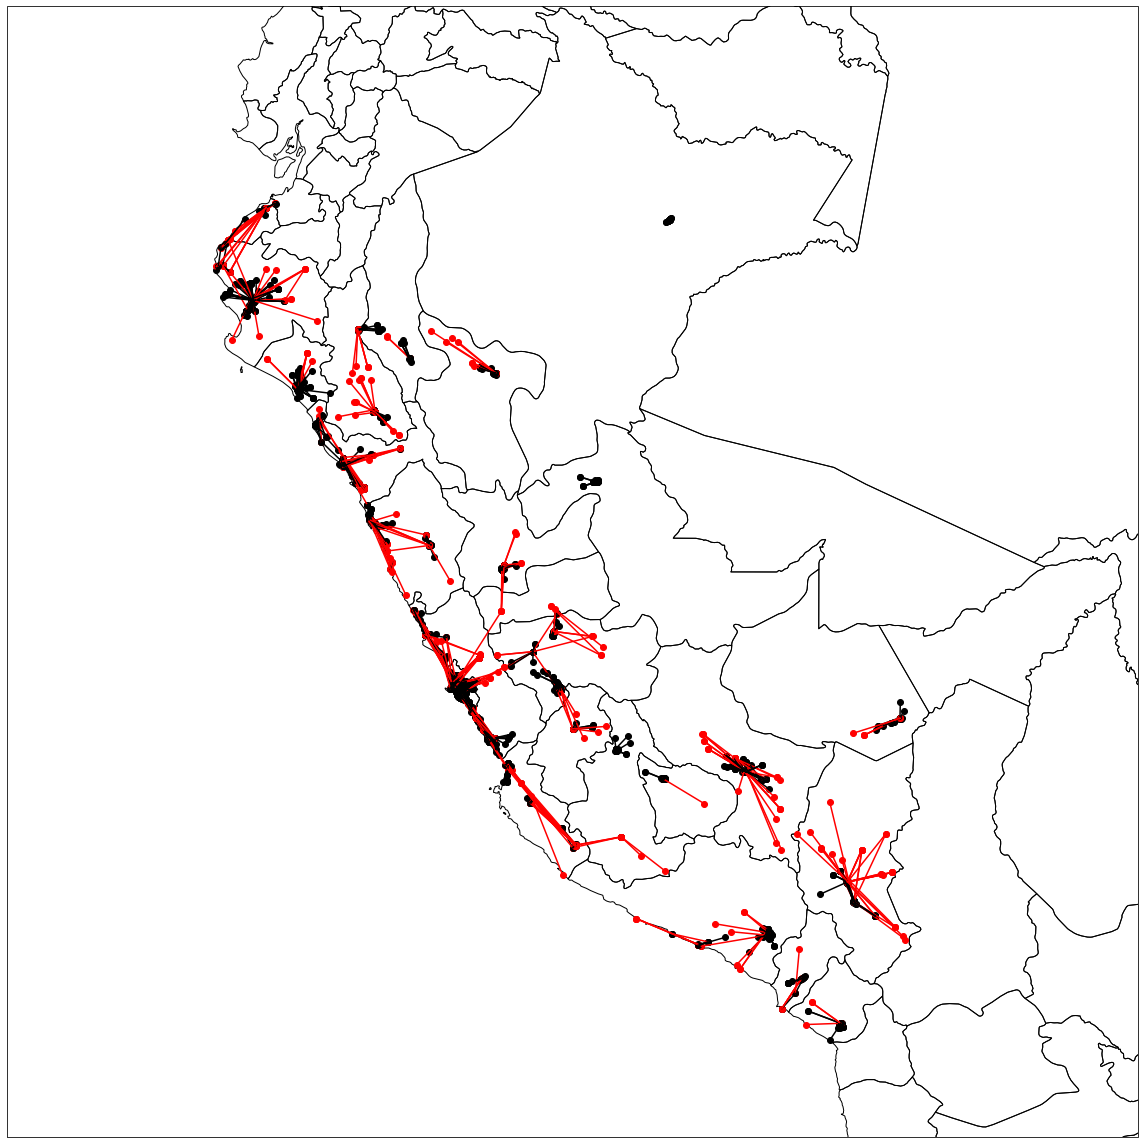

In [14]:
proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16,16))
ax.set_extent([-85,
               -65,
               -20,
               0], 
              crs=ccrs.PlateCarree())

lo_orig = train_data['longitud_origen'].tolist()
la_orig = train_data['latitud_origen'].tolist()
lo_dest = train_data['longitud_destino'].tolist()
la_dest = train_data['latitud_destino'].tolist()


for x1, y1, x2, y2, clus in zip(lo_orig,la_orig,lo_dest,la_dest,labels):
    if clus == 0:
        ax.scatter(x1, y1,c='k')
        ax.scatter(x2, y2,c='k')

        x_values = [x1,x2]
        y_values = [y1,y2]

        ax.plot(x_values,y_values,'k-')
    else:
        ax.scatter(x1, y1,c='r')
        ax.scatter(x2, y2,c='r')

        x_values = [x1,x2]
        y_values = [y1,y2]

        ax.plot(x_values,y_values,'r-')
    
ax.add_feature(cfeature.STATES.with_scale('10m'), zorder=0)

fig.canvas.draw()
fig.tight_layout()

plt.show()

In [15]:
values, counts = np.unique(labels, return_counts=True)

In [16]:
print(values,counts)

[0 1] [1678  274]


In [17]:
X0 = []
X1 = []
y0 = []
y1 = []

for el_x, el_y, label in zip(X,y,labels):
    if label == 0:
        X0.append(el_x)
        y0.append(el_y)
    else:
        X1.append(el_x)
        y1.append(el_y)

In [18]:
print(len(X0),len(y0))
print(len(X1),len(y1))

1678 1678
274 274


In [19]:
from keras.optimizers import Adam

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer=Adam(learning_rate=0.5e-2))
    return model

In [20]:
from keras.callbacks import ModelCheckpoint

def get_callbacks_0():
    filepath = 'data/out/try9_0.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try9_0.csv')
    
    return [callback1,callback2]

In [21]:
def get_callbacks_1():
    filepath = 'data/out/try9_1.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try9_1.csv')
    
    return [callback1,callback2]

In [22]:
# Para cluster 0

n_inputs, n_outputs = len(X0[1]), len(y0[1])

model_0 = get_model(n_inputs, n_outputs)
history_0 = model_0.fit(np.array(X0), np.array(y0), verbose=1, epochs=1000, validation_split=0.2, callbacks=get_callbacks_0())

Epoch 1/1000
42/42 [==============================] - 1s 23ms/step - loss: 97.9639 - val_loss: 28.5676

Epoch 00001: loss improved from inf to 64.04192, saving model to data/out\try9_0.h5
Epoch 2/1000
42/42 [==============================] - 0s 2ms/step - loss: 22.4567 - val_loss: 17.0993

Epoch 00002: loss improved from 64.04192 to 19.56030, saving model to data/out\try9_0.h5
Epoch 3/1000
42/42 [==============================] - 0s 2ms/step - loss: 16.7670 - val_loss: 16.0533

Epoch 00003: loss improved from 19.56030 to 16.43021, saving model to data/out\try9_0.h5
Epoch 4/1000
42/42 [==============================] - 0s 2ms/step - loss: 15.5763 - val_loss: 15.9576

Epoch 00004: loss improved from 16.43021 to 15.34578, saving model to data/out\try9_0.h5
Epoch 5/1000
42/42 [==============================] - 0s 2ms/step - loss: 15.0176 - val_loss: 15.0542

Epoch 00005: loss improved from 15.34578 to 14.75353, saving model to data/out\try9_0.h5
Epoch 6/1000
42/42 [========================

42/42 [==============================] - 0s 1ms/step - loss: 13.0033 - val_loss: 14.9490

Epoch 00050: loss did not improve from 12.50045
Epoch 51/1000
42/42 [==============================] - 0s 1ms/step - loss: 13.1951 - val_loss: 13.3157

Epoch 00051: loss did not improve from 12.50045
Epoch 52/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.4290 - val_loss: 13.2885

Epoch 00052: loss improved from 12.50045 to 12.44015, saving model to data/out\try9_0.h5
Epoch 53/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.6810 - val_loss: 13.2223

Epoch 00053: loss did not improve from 12.44015
Epoch 54/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.9626 - val_loss: 13.3759

Epoch 00054: loss improved from 12.44015 to 12.38112, saving model to data/out\try9_0.h5
Epoch 55/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.5143 - val_loss: 13.4957

Epoch 00055: loss did not improve from 12.38112
Epoch 56/1000
42/42 


Epoch 00101: loss did not improve from 12.07254
Epoch 102/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.4310 - val_loss: 13.3857

Epoch 00102: loss did not improve from 12.07254
Epoch 103/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.6418 - val_loss: 13.1406

Epoch 00103: loss did not improve from 12.07254
Epoch 104/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.8627 - val_loss: 13.2262

Epoch 00104: loss improved from 12.07254 to 12.05989, saving model to data/out\try9_0.h5
Epoch 105/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.9810 - val_loss: 13.2202

Epoch 00105: loss did not improve from 12.05989
Epoch 106/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.9442 - val_loss: 13.0743

Epoch 00106: loss did not improve from 12.05989
Epoch 107/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.1036 - val_loss: 13.0819

Epoch 00107: loss did not improve from 1

42/42 [==============================] - 0s 1ms/step - loss: 12.1507 - val_loss: 13.6593

Epoch 00154: loss did not improve from 11.97155
Epoch 155/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.2879 - val_loss: 13.2099

Epoch 00155: loss did not improve from 11.97155
Epoch 156/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.6664 - val_loss: 12.9577

Epoch 00156: loss did not improve from 11.97155
Epoch 157/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.4666 - val_loss: 12.9536

Epoch 00157: loss did not improve from 11.97155
Epoch 158/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.7348 - val_loss: 13.2416

Epoch 00158: loss did not improve from 11.97155
Epoch 159/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.0280 - val_loss: 13.0775

Epoch 00159: loss did not improve from 11.97155
Epoch 160/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.0754 - val_loss: 1


Epoch 00206: loss did not improve from 11.80535
Epoch 207/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.6891 - val_loss: 13.3012

Epoch 00207: loss did not improve from 11.80535
Epoch 208/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.3193 - val_loss: 12.8085

Epoch 00208: loss did not improve from 11.80535
Epoch 209/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.8153 - val_loss: 13.3377

Epoch 00209: loss did not improve from 11.80535
Epoch 210/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.2315 - val_loss: 12.9951

Epoch 00210: loss did not improve from 11.80535
Epoch 211/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.5264 - val_loss: 12.9946

Epoch 00211: loss did not improve from 11.80535
Epoch 212/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.1561 - val_loss: 13.0304

Epoch 00212: loss did not improve from 11.80535
Epoch 213/1000
42/42 [===========

42/42 [==============================] - 0s 1ms/step - loss: 11.7001 - val_loss: 13.8283

Epoch 00260: loss did not improve from 11.80535
Epoch 261/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.9277 - val_loss: 12.7959

Epoch 00261: loss did not improve from 11.80535
Epoch 262/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.2223 - val_loss: 12.9919

Epoch 00262: loss did not improve from 11.80535
Epoch 263/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.9201 - val_loss: 12.7381

Epoch 00263: loss did not improve from 11.80535
Epoch 264/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.0458 - val_loss: 14.4537

Epoch 00264: loss did not improve from 11.80535
Epoch 265/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.8088 - val_loss: 12.7648

Epoch 00265: loss did not improve from 11.80535
Epoch 266/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.6108 - val_loss: 1

42/42 [==============================] - 0s 2ms/step - loss: 11.2862 - val_loss: 12.9752

Epoch 00313: loss did not improve from 11.69183
Epoch 314/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.9671 - val_loss: 13.0613

Epoch 00314: loss did not improve from 11.69183
Epoch 315/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.7811 - val_loss: 12.6335

Epoch 00315: loss did not improve from 11.69183
Epoch 316/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.3962 - val_loss: 12.6604

Epoch 00316: loss did not improve from 11.69183
Epoch 317/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.9157 - val_loss: 12.7052

Epoch 00317: loss did not improve from 11.69183
Epoch 318/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.4823 - val_loss: 12.7011

Epoch 00318: loss did not improve from 11.69183
Epoch 319/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.1953 - val_loss: 1

42/42 [==============================] - 0s 2ms/step - loss: 12.3965 - val_loss: 13.0430

Epoch 00366: loss did not improve from 11.61589
Epoch 367/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.2395 - val_loss: 14.1484

Epoch 00367: loss did not improve from 11.61589
Epoch 368/1000
42/42 [==============================] - 0s 3ms/step - loss: 12.5973 - val_loss: 12.5593

Epoch 00368: loss did not improve from 11.61589
Epoch 369/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.8338 - val_loss: 12.5910

Epoch 00369: loss did not improve from 11.61589
Epoch 370/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4031 - val_loss: 12.6229

Epoch 00370: loss did not improve from 11.61589
Epoch 371/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.9031 - val_loss: 12.6127

Epoch 00371: loss did not improve from 11.61589
Epoch 372/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.0087 - val_loss: 1

Epoch 419/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.3603 - val_loss: 12.7003

Epoch 00419: loss did not improve from 11.54319
Epoch 420/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.3657 - val_loss: 12.5401

Epoch 00420: loss did not improve from 11.54319
Epoch 421/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.9912 - val_loss: 12.6606

Epoch 00421: loss did not improve from 11.54319
Epoch 422/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.3867 - val_loss: 12.5829

Epoch 00422: loss improved from 11.54319 to 11.51815, saving model to data/out\try9_0.h5
Epoch 423/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.7559 - val_loss: 12.5418

Epoch 00423: loss did not improve from 11.51815
Epoch 424/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.4408 - val_loss: 12.5418

Epoch 00424: loss did not improve from 11.51815
Epoch 425/1000
42/42 [===================

42/42 [==============================] - 0s 2ms/step - loss: 11.6315 - val_loss: 12.9963

Epoch 00472: loss improved from 11.50924 to 11.47942, saving model to data/out\try9_0.h5
Epoch 473/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.2337 - val_loss: 13.0629

Epoch 00473: loss did not improve from 11.47942
Epoch 474/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4540 - val_loss: 12.5462

Epoch 00474: loss did not improve from 11.47942
Epoch 475/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.0766 - val_loss: 12.9659

Epoch 00475: loss did not improve from 11.47942
Epoch 476/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.5649 - val_loss: 12.7645

Epoch 00476: loss did not improve from 11.47942
Epoch 477/1000
42/42 [==============================] - 0s 1ms/step - loss: 12.3969 - val_loss: 12.5245

Epoch 00477: loss did not improve from 11.47942
Epoch 478/1000
42/42 [==============================] - 

42/42 [==============================] - 0s 1ms/step - loss: 11.5982 - val_loss: 12.7453

Epoch 00525: loss did not improve from 11.47299
Epoch 526/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.7218 - val_loss: 12.9853

Epoch 00526: loss did not improve from 11.47299
Epoch 527/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.9436 - val_loss: 12.6878

Epoch 00527: loss did not improve from 11.47299
Epoch 528/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.1852 - val_loss: 12.8461

Epoch 00528: loss did not improve from 11.47299
Epoch 529/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.6503 - val_loss: 12.5872

Epoch 00529: loss did not improve from 11.47299
Epoch 530/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.5966 - val_loss: 12.9797

Epoch 00530: loss did not improve from 11.47299
Epoch 531/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4192 - val_loss: 1


Epoch 00577: loss did not improve from 11.44704
Epoch 578/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.8098 - val_loss: 12.5693

Epoch 00578: loss did not improve from 11.44704
Epoch 579/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.6488 - val_loss: 12.5420

Epoch 00579: loss did not improve from 11.44704
Epoch 580/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.6710 - val_loss: 13.1061

Epoch 00580: loss did not improve from 11.44704
Epoch 581/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.6766 - val_loss: 12.5589

Epoch 00581: loss did not improve from 11.44704
Epoch 582/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.9525 - val_loss: 12.8557

Epoch 00582: loss did not improve from 11.44704
Epoch 583/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.5797 - val_loss: 12.5004

Epoch 00583: loss did not improve from 11.44704
Epoch 584/1000
42/42 [===========

42/42 [==============================] - 0s 2ms/step - loss: 11.7796 - val_loss: 12.5775

Epoch 00630: loss did not improve from 11.37198
Epoch 631/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.0224 - val_loss: 12.5811

Epoch 00631: loss did not improve from 11.37198
Epoch 632/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.5134 - val_loss: 12.5402

Epoch 00632: loss did not improve from 11.37198
Epoch 633/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.8213 - val_loss: 12.7641

Epoch 00633: loss did not improve from 11.37198
Epoch 634/1000
42/42 [==============================] - 0s 2ms/step - loss: 10.9223 - val_loss: 12.4754

Epoch 00634: loss did not improve from 11.37198
Epoch 635/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.5150 - val_loss: 12.6270

Epoch 00635: loss did not improve from 11.37198
Epoch 636/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.0365 - val_loss: 1

42/42 [==============================] - 0s 1ms/step - loss: 11.8303 - val_loss: 12.5536

Epoch 00683: loss did not improve from 11.29871
Epoch 684/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.6982 - val_loss: 12.6508

Epoch 00684: loss did not improve from 11.29871
Epoch 685/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.3793 - val_loss: 12.5005

Epoch 00685: loss did not improve from 11.29871
Epoch 686/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.8936 - val_loss: 12.5301

Epoch 00686: loss did not improve from 11.29871
Epoch 687/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.0930 - val_loss: 12.7134

Epoch 00687: loss did not improve from 11.29871
Epoch 688/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.6369 - val_loss: 12.6995

Epoch 00688: loss did not improve from 11.29871
Epoch 689/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.4415 - val_loss: 1


Epoch 00736: loss did not improve from 11.29871
Epoch 737/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4659 - val_loss: 12.6306

Epoch 00737: loss did not improve from 11.29871
Epoch 738/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4502 - val_loss: 12.5916

Epoch 00738: loss did not improve from 11.29871
Epoch 739/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4352 - val_loss: 12.6352

Epoch 00739: loss did not improve from 11.29871
Epoch 740/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.1136 - val_loss: 12.6307

Epoch 00740: loss did not improve from 11.29871
Epoch 741/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.5738 - val_loss: 12.4973

Epoch 00741: loss did not improve from 11.29871
Epoch 742/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.6881 - val_loss: 12.6665

Epoch 00742: loss did not improve from 11.29871
Epoch 743/1000
42/42 [===========

42/42 [==============================] - 0s 2ms/step - loss: 11.7151 - val_loss: 12.5989

Epoch 00789: loss did not improve from 11.25588
Epoch 790/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.3541 - val_loss: 12.6672

Epoch 00790: loss did not improve from 11.25588
Epoch 791/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.6780 - val_loss: 12.7335

Epoch 00791: loss did not improve from 11.25588
Epoch 792/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.4173 - val_loss: 12.5845

Epoch 00792: loss did not improve from 11.25588
Epoch 793/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.3428 - val_loss: 12.7860

Epoch 00793: loss did not improve from 11.25588
Epoch 794/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.1295 - val_loss: 12.7276

Epoch 00794: loss did not improve from 11.25588
Epoch 795/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.2662 - val_loss: 1


Epoch 00842: loss did not improve from 11.25588
Epoch 843/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.1348 - val_loss: 12.7216

Epoch 00843: loss did not improve from 11.25588
Epoch 844/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.5902 - val_loss: 12.5059

Epoch 00844: loss did not improve from 11.25588
Epoch 845/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.0330 - val_loss: 12.4292

Epoch 00845: loss did not improve from 11.25588
Epoch 846/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4644 - val_loss: 12.4789

Epoch 00846: loss did not improve from 11.25588
Epoch 847/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.7813 - val_loss: 12.5888

Epoch 00847: loss did not improve from 11.25588
Epoch 848/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.1308 - val_loss: 12.5421

Epoch 00848: loss did not improve from 11.25588
Epoch 849/1000
42/42 [===========

42/42 [==============================] - 0s 2ms/step - loss: 11.4799 - val_loss: 12.6556

Epoch 00896: loss did not improve from 11.25588
Epoch 897/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.3040 - val_loss: 12.5405

Epoch 00897: loss did not improve from 11.25588
Epoch 898/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4163 - val_loss: 12.7154

Epoch 00898: loss did not improve from 11.25588
Epoch 899/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.0127 - val_loss: 12.9433

Epoch 00899: loss did not improve from 11.25588
Epoch 900/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.2348 - val_loss: 12.4817

Epoch 00900: loss did not improve from 11.25588
Epoch 901/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.4127 - val_loss: 12.5381

Epoch 00901: loss did not improve from 11.25588
Epoch 902/1000
42/42 [==============================] - 0s 1ms/step - loss: 10.9435 - val_loss: 1

42/42 [==============================] - 0s 2ms/step - loss: 11.4581 - val_loss: 12.4676

Epoch 00949: loss did not improve from 11.20985
Epoch 950/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.0990 - val_loss: 13.0018

Epoch 00950: loss did not improve from 11.20985
Epoch 951/1000
42/42 [==============================] - 0s 1ms/step - loss: 11.2226 - val_loss: 12.7005

Epoch 00951: loss did not improve from 11.20985
Epoch 952/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.6059 - val_loss: 12.6813

Epoch 00952: loss did not improve from 11.20985
Epoch 953/1000
42/42 [==============================] - 0s 2ms/step - loss: 10.9218 - val_loss: 12.4785

Epoch 00953: loss did not improve from 11.20985
Epoch 954/1000
42/42 [==============================] - 0s 2ms/step - loss: 11.2488 - val_loss: 13.5435

Epoch 00954: loss did not improve from 11.20985
Epoch 955/1000
42/42 [==============================] - 0s 2ms/step - loss: 12.1341 - val_loss: 1

In [23]:
#Cargando el mejor modelo

from keras.models import load_model

best_model_tf_0 = load_model('data/out/try9_0.h5')

best_model_tf_0.evaluate(np.array(X0),np.array(y0))

53/53 [==============================] - 0s 442us/step - loss: 11.4637


11.46366024017334

In [24]:
model_1 = get_model(n_inputs, n_outputs)
history_1 = model_1.fit(np.array(X1), np.array(y1), verbose=1, epochs=1000, validation_split=0.2, callbacks=get_callbacks_1())

Epoch 1/1000
7/7 [==============================] - 0s 22ms/step - loss: 59.9014 - val_loss: 35.3161

Epoch 00001: loss improved from inf to 46.82227, saving model to data/out\try9_1.h5
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 26.8678 - val_loss: 19.5444

Epoch 00002: loss improved from 46.82227 to 23.85032, saving model to data/out\try9_1.h5
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 15.6934 - val_loss: 18.7354

Epoch 00003: loss improved from 23.85032 to 15.19761, saving model to data/out\try9_1.h5
Epoch 4/1000
7/7 [==============================] - 0s 6ms/step - loss: 14.8628 - val_loss: 15.2758

Epoch 00004: loss improved from 15.19761 to 14.72647, saving model to data/out\try9_1.h5
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 13.3164 - val_loss: 14.1068

Epoch 00005: loss improved from 14.72647 to 13.52609, saving model to data/out\try9_1.h5
Epoch 6/1000
7/7 [==============================] - 0s

7/7 [==============================] - 0s 6ms/step - loss: 11.2331 - val_loss: 12.8956

Epoch 00050: loss did not improve from 10.39803
Epoch 51/1000
7/7 [==============================] - 0s 7ms/step - loss: 11.8645 - val_loss: 12.6365

Epoch 00051: loss did not improve from 10.39803
Epoch 52/1000
7/7 [==============================] - 0s 7ms/step - loss: 11.1869 - val_loss: 12.2518

Epoch 00052: loss did not improve from 10.39803
Epoch 53/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.3627 - val_loss: 13.1220

Epoch 00053: loss did not improve from 10.39803
Epoch 54/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.4497 - val_loss: 12.2246

Epoch 00054: loss did not improve from 10.39803
Epoch 55/1000
7/7 [==============================] - 0s 6ms/step - loss: 11.2428 - val_loss: 12.2639

Epoch 00055: loss did not improve from 10.39803
Epoch 56/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.6448 - val_loss: 12.2525

Epoch 00056:

7/7 [==============================] - 0s 6ms/step - loss: 10.0551 - val_loss: 12.2910

Epoch 00104: loss did not improve from 10.21387
Epoch 105/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.8087 - val_loss: 12.3471

Epoch 00105: loss did not improve from 10.21387
Epoch 106/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.7236 - val_loss: 13.3353

Epoch 00106: loss did not improve from 10.21387
Epoch 107/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.3653 - val_loss: 12.3610

Epoch 00107: loss improved from 10.21387 to 10.15386, saving model to data/out\try9_1.h5
Epoch 108/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.6441 - val_loss: 12.1960

Epoch 00108: loss did not improve from 10.15386
Epoch 109/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7510 - val_loss: 12.5848

Epoch 00109: loss did not improve from 10.15386
Epoch 110/1000
7/7 [==============================] - 0s 6ms/step - l

7/7 [==============================] - 0s 6ms/step - loss: 10.3300 - val_loss: 12.2934

Epoch 00157: loss did not improve from 10.04984
Epoch 158/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.3825 - val_loss: 12.1171

Epoch 00158: loss did not improve from 10.04984
Epoch 159/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8787 - val_loss: 12.0995

Epoch 00159: loss did not improve from 10.04984
Epoch 160/1000
7/7 [==============================] - 0s 7ms/step - loss: 9.9324 - val_loss: 12.3049

Epoch 00160: loss did not improve from 10.04984
Epoch 161/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8661 - val_loss: 12.4839

Epoch 00161: loss did not improve from 10.04984
Epoch 162/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.8119 - val_loss: 12.1752

Epoch 00162: loss did not improve from 10.04984
Epoch 163/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8233 - val_loss: 12.1891

Epoch 0016

7/7 [==============================] - 0s 6ms/step - loss: 10.5090 - val_loss: 12.0703

Epoch 00211: loss did not improve from 9.90888
Epoch 212/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.0809 - val_loss: 12.2195

Epoch 00212: loss did not improve from 9.90888
Epoch 213/1000
7/7 [==============================] - 0s 8ms/step - loss: 9.8003 - val_loss: 12.3187

Epoch 00213: loss did not improve from 9.90888
Epoch 214/1000
7/7 [==============================] - 0s 8ms/step - loss: 10.6736 - val_loss: 12.0927

Epoch 00214: loss did not improve from 9.90888
Epoch 215/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.1143 - val_loss: 12.4614

Epoch 00215: loss did not improve from 9.90888
Epoch 216/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.1859 - val_loss: 12.2972

Epoch 00216: loss did not improve from 9.90888
Epoch 217/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.3584 - val_loss: 12.2708

Epoch 00217: 

7/7 [==============================] - 0s 6ms/step - loss: 11.0344 - val_loss: 12.0186

Epoch 00266: loss did not improve from 9.90888
Epoch 267/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.9445 - val_loss: 11.9621

Epoch 00267: loss did not improve from 9.90888
Epoch 268/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.3654 - val_loss: 12.0129

Epoch 00268: loss did not improve from 9.90888
Epoch 269/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8785 - val_loss: 12.0480

Epoch 00269: loss did not improve from 9.90888
Epoch 270/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6848 - val_loss: 13.4800

Epoch 00270: loss did not improve from 9.90888
Epoch 271/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.9397 - val_loss: 12.9647

Epoch 00271: loss did not improve from 9.90888
Epoch 272/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8815 - val_loss: 11.9838

Epoch 00272: loss

7/7 [==============================] - 0s 6ms/step - loss: 10.5369 - val_loss: 12.1560

Epoch 00321: loss did not improve from 9.90888
Epoch 322/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.1741 - val_loss: 13.5888

Epoch 00322: loss did not improve from 9.90888
Epoch 323/1000
7/7 [==============================] - 0s 6ms/step - loss: 11.7614 - val_loss: 11.9714

Epoch 00323: loss did not improve from 9.90888
Epoch 324/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.0617 - val_loss: 11.9088

Epoch 00324: loss did not improve from 9.90888
Epoch 325/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.9356 - val_loss: 12.1719

Epoch 00325: loss did not improve from 9.90888
Epoch 326/1000
7/7 [==============================] - 0s 6ms/step - loss: 11.5118 - val_loss: 12.4030

Epoch 00326: loss did not improve from 9.90888
Epoch 327/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.6514 - val_loss: 13.0069

Epoch 00327: 

7/7 [==============================] - 0s 6ms/step - loss: 11.2263 - val_loss: 11.9476

Epoch 00375: loss did not improve from 9.88774
Epoch 376/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.2300 - val_loss: 11.9464

Epoch 00376: loss did not improve from 9.88774
Epoch 377/1000
7/7 [==============================] - 0s 8ms/step - loss: 10.2398 - val_loss: 12.2870

Epoch 00377: loss did not improve from 9.88774
Epoch 378/1000
7/7 [==============================] - 0s 10ms/step - loss: 10.9369 - val_loss: 11.8635

Epoch 00378: loss did not improve from 9.88774
Epoch 379/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.5438 - val_loss: 11.8529

Epoch 00379: loss did not improve from 9.88774
Epoch 380/1000
7/7 [==============================] - 0s 7ms/step - loss: 9.5055 - val_loss: 12.3767

Epoch 00380: loss improved from 9.88774 to 9.83432, saving model to data/out\try9_1.h5
Epoch 381/1000
7/7 [==============================] - 0s 6ms/step - loss: 1


Epoch 00429: loss did not improve from 9.83432
Epoch 430/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.2422 - val_loss: 13.3116

Epoch 00430: loss did not improve from 9.83432
Epoch 431/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.2904 - val_loss: 11.7674

Epoch 00431: loss did not improve from 9.83432
Epoch 432/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7058 - val_loss: 12.0487

Epoch 00432: loss did not improve from 9.83432
Epoch 433/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7774 - val_loss: 11.7492

Epoch 00433: loss did not improve from 9.83432
Epoch 434/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8187 - val_loss: 12.5755

Epoch 00434: loss did not improve from 9.83432
Epoch 435/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.6041 - val_loss: 13.0297

Epoch 00435: loss did not improve from 9.83432
Epoch 436/1000
7/7 [==============================] - 0

7/7 [==============================] - 0s 6ms/step - loss: 10.3651 - val_loss: 11.6393

Epoch 00484: loss did not improve from 9.74462
Epoch 485/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.2939 - val_loss: 11.6759

Epoch 00485: loss did not improve from 9.74462
Epoch 486/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.0476 - val_loss: 11.6269

Epoch 00486: loss did not improve from 9.74462
Epoch 487/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.2298 - val_loss: 11.6049

Epoch 00487: loss did not improve from 9.74462
Epoch 488/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.3608 - val_loss: 11.8465

Epoch 00488: loss did not improve from 9.74462
Epoch 489/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.1283 - val_loss: 11.5979

Epoch 00489: loss did not improve from 9.74462
Epoch 490/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7187 - val_loss: 11.6400

Epoch 00490: lo

7/7 [==============================] - 0s 7ms/step - loss: 10.1651 - val_loss: 11.5385

Epoch 00538: loss did not improve from 9.60830
Epoch 539/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6496 - val_loss: 11.5261

Epoch 00539: loss did not improve from 9.60830
Epoch 540/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7667 - val_loss: 12.5014

Epoch 00540: loss did not improve from 9.60830
Epoch 541/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.1368 - val_loss: 11.7353

Epoch 00541: loss did not improve from 9.60830
Epoch 542/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.1900 - val_loss: 11.4997

Epoch 00542: loss did not improve from 9.60830
Epoch 543/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.9532 - val_loss: 13.6748

Epoch 00543: loss did not improve from 9.60830
Epoch 544/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.7367 - val_loss: 11.8231

Epoch 00544: lo


Epoch 00592: loss did not improve from 9.57912
Epoch 593/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.4274 - val_loss: 13.1786

Epoch 00593: loss did not improve from 9.57912
Epoch 594/1000
7/7 [==============================] - 0s 8ms/step - loss: 11.0868 - val_loss: 11.4468

Epoch 00594: loss did not improve from 9.57912
Epoch 595/1000
7/7 [==============================] - 0s 8ms/step - loss: 9.9409 - val_loss: 11.9496

Epoch 00595: loss did not improve from 9.57912
Epoch 596/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.7557 - val_loss: 11.8014

Epoch 00596: loss did not improve from 9.57912
Epoch 597/1000
7/7 [==============================] - 0s 7ms/step - loss: 10.4705 - val_loss: 11.4005

Epoch 00597: loss did not improve from 9.57912
Epoch 598/1000
7/7 [==============================] - 0s 7ms/step - loss: 9.5018 - val_loss: 11.5458

Epoch 00598: loss did not improve from 9.57912
Epoch 599/1000
7/7 [==============================] - 

7/7 [==============================] - 0s 6ms/step - loss: 10.2859 - val_loss: 11.3660

Epoch 00647: loss did not improve from 9.57912
Epoch 648/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.5053 - val_loss: 13.8867

Epoch 00648: loss did not improve from 9.57912
Epoch 649/1000
7/7 [==============================] - 0s 6ms/step - loss: 12.0789 - val_loss: 11.3908

Epoch 00649: loss did not improve from 9.57912
Epoch 650/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6960 - val_loss: 11.3206

Epoch 00650: loss did not improve from 9.57912
Epoch 651/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.4412 - val_loss: 11.3901

Epoch 00651: loss did not improve from 9.57912
Epoch 652/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.2688 - val_loss: 12.1454

Epoch 00652: loss did not improve from 9.57912
Epoch 653/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.0794 - val_loss: 11.4584

Epoch 00653: l

7/7 [==============================] - 0s 6ms/step - loss: 9.7329 - val_loss: 11.2782

Epoch 00701: loss did not improve from 9.51375
Epoch 702/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.3406 - val_loss: 11.2053

Epoch 00702: loss did not improve from 9.51375
Epoch 703/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.1405 - val_loss: 11.2350

Epoch 00703: loss did not improve from 9.51375
Epoch 704/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7759 - val_loss: 11.2002

Epoch 00704: loss did not improve from 9.51375
Epoch 705/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.3319 - val_loss: 11.1962

Epoch 00705: loss did not improve from 9.51375
Epoch 706/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8777 - val_loss: 11.3355

Epoch 00706: loss did not improve from 9.51375
Epoch 707/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.2719 - val_loss: 14.5397

Epoch 00707: loss d

7/7 [==============================] - 0s 6ms/step - loss: 9.2453 - val_loss: 11.2907

Epoch 00755: loss did not improve from 9.41265
Epoch 756/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6311 - val_loss: 12.0009

Epoch 00756: loss did not improve from 9.41265
Epoch 757/1000
7/7 [==============================] - 0s 6ms/step - loss: 11.1868 - val_loss: 11.2221

Epoch 00757: loss did not improve from 9.41265
Epoch 758/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.8824 - val_loss: 11.1506

Epoch 00758: loss did not improve from 9.41265
Epoch 759/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7610 - val_loss: 11.3162

Epoch 00759: loss did not improve from 9.41265
Epoch 760/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7232 - val_loss: 11.4077

Epoch 00760: loss did not improve from 9.41265
Epoch 761/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7704 - val_loss: 11.1724

Epoch 00761: loss 

7/7 [==============================] - 0s 6ms/step - loss: 9.4029 - val_loss: 11.0972

Epoch 00810: loss did not improve from 9.36638
Epoch 811/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.3883 - val_loss: 11.3472

Epoch 00811: loss did not improve from 9.36638
Epoch 812/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.7035 - val_loss: 11.1130

Epoch 00812: loss did not improve from 9.36638
Epoch 813/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.0947 - val_loss: 11.0059

Epoch 00813: loss did not improve from 9.36638
Epoch 814/1000
7/7 [==============================] - 0s 6ms/step - loss: 10.0085 - val_loss: 11.1689

Epoch 00814: loss did not improve from 9.36638
Epoch 815/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.3959 - val_loss: 11.2573

Epoch 00815: loss did not improve from 9.36638
Epoch 816/1000
7/7 [==============================] - 0s 7ms/step - loss: 9.5075 - val_loss: 11.2563

Epoch 00816: loss

7/7 [==============================] - 0s 6ms/step - loss: 9.4669 - val_loss: 10.8881

Epoch 00864: loss did not improve from 9.32224
Epoch 865/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8697 - val_loss: 11.1169

Epoch 00865: loss did not improve from 9.32224
Epoch 866/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6039 - val_loss: 11.1098

Epoch 00866: loss did not improve from 9.32224
Epoch 867/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.5813 - val_loss: 11.1080

Epoch 00867: loss did not improve from 9.32224
Epoch 868/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.2132 - val_loss: 12.0377

Epoch 00868: loss did not improve from 9.32224
Epoch 869/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.4668 - val_loss: 11.0655

Epoch 00869: loss did not improve from 9.32224
Epoch 870/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6962 - val_loss: 10.8930

Epoch 00870: loss d


Epoch 00918: loss did not improve from 9.27199
Epoch 919/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.8734 - val_loss: 10.7292

Epoch 00919: loss did not improve from 9.27199
Epoch 920/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.4093 - val_loss: 11.7360

Epoch 00920: loss did not improve from 9.27199
Epoch 921/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6922 - val_loss: 11.5237

Epoch 00921: loss did not improve from 9.27199
Epoch 922/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7406 - val_loss: 10.8088

Epoch 00922: loss did not improve from 9.27199
Epoch 923/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.5699 - val_loss: 11.2342

Epoch 00923: loss did not improve from 9.27199
Epoch 924/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.5770 - val_loss: 11.5873

Epoch 00924: loss did not improve from 9.27199
Epoch 925/1000
7/7 [==============================] - 0s 6

7/7 [==============================] - 0s 6ms/step - loss: 10.2889 - val_loss: 11.1327

Epoch 00973: loss did not improve from 9.18900
Epoch 974/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.1513 - val_loss: 12.4583

Epoch 00974: loss did not improve from 9.18900
Epoch 975/1000
7/7 [==============================] - 0s 7ms/step - loss: 9.3901 - val_loss: 10.6151

Epoch 00975: loss did not improve from 9.18900
Epoch 976/1000
7/7 [==============================] - 0s 7ms/step - loss: 9.2583 - val_loss: 10.7699

Epoch 00976: loss did not improve from 9.18900
Epoch 977/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.9009 - val_loss: 10.7346

Epoch 00977: loss did not improve from 9.18900
Epoch 978/1000
7/7 [==============================] - 0s 9ms/step - loss: 9.7725 - val_loss: 10.7478

Epoch 00978: loss did not improve from 9.18900
Epoch 979/1000
7/7 [==============================] - 0s 8ms/step - loss: 10.0566 - val_loss: 10.8529

Epoch 00979: loss

In [25]:
best_model_tf_1 = load_model('data/out/try9_1.h5')

best_model_tf_1.evaluate(np.array(X1),np.array(y1))

9/9 [==============================] - 0s 750us/step - loss: 9.4409


9.440930366516113

In [26]:
from joblib import load

cluster_model = load('data/out/cluster_model_t9.joblib') 
yhat_pred = cluster_model.predict(yhat)

In [27]:
ypred = []

for y, label in zip(yhat,yhat_pred):
    y = np.expand_dims(y, 0)
    if label == 0:
        pred = best_model_tf_0.predict(y)[0].tolist()
    else:
        pred = best_model_tf_1.predict(y)[0].tolist()
    ypred.append(pred)

In [28]:
ypred = np.asarray(ypred)

In [29]:
ids = pd.read_csv(test_file)
ids_1 = ids['id']

In [30]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   76498.039062   5159.397461
1    124093149  125777.195312  10512.606445
2    124090750   21230.097656   2485.685547
3    124092491   12543.418945   1591.377319
4    124091871    9614.801758   1024.070312
..         ...            ...           ...
847  124088805   15479.424805   2141.057373
848  124089757   12303.350586   1628.104492
849  124089569   24894.144531   2544.073975
850  124092518   91951.820312   6740.317383
851  124090644  167856.500000   9979.481445

[852 rows x 3 columns]


In [31]:
df.to_csv('data/out/try9_out.csv',index=False)

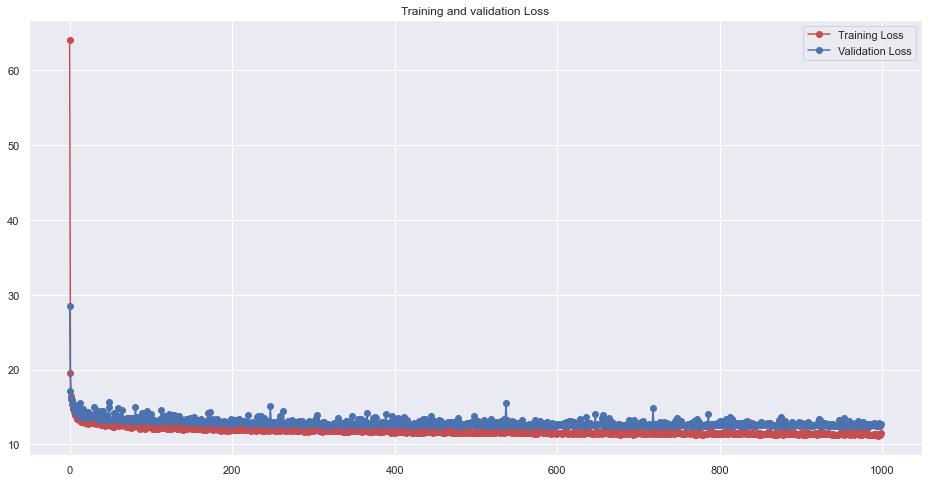

<Figure size 432x288 with 0 Axes>

In [32]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

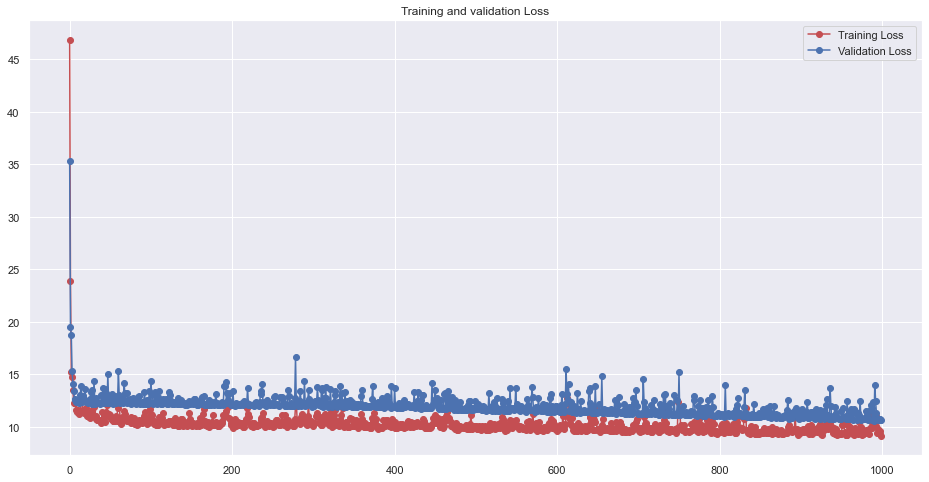

<Figure size 432x288 with 0 Axes>

In [33]:
sns.set()
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()